# Adversarial Autoencoder

Adversarial autoencoder is regularized by matching the aggregated posterior $q(z)$ to an arbitrary prior distribution $p(z)$. The generator of the adversarial network is also the encoder of the autoencoder $q(z|x)$. The encoder or generator of the network ensures the aggregated posterior distribution can fool the discriminative adversarial network into thinking that the hidden code $q(z)$ comes from the true prior distribution $p(z)$.

Adversarial autoencoder is trained jointly in two phases - reconstruction phase and regularisation phase. In reconstruction phase, autoencoder updates the encoder and decoder to minimise the reconstruction error. In regularisation phase, adversarial network first updates its discriminator to tell apart true samples (generated using the prior $p(z)$) from the generated samples (generated by encoder or generator aggregrated posterior $q(z)$). The adversarial network then updates its generator to confuse the discriminator. Once training is done, decoder will define the generative model that maps the imposed prior $p(z)$ to the data distribution $p_d(x)$



In [17]:
import pickle
import numpy as np
import pandas as pd
import tqdm
import os
import datetime
import glob

# pytorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

print("pandas.__version", pd.__version__)
print("torch.__version__:", torch.__version__)

pandas.__version 0.20.3
torch.__version__: 0.2.0_3


# Arguments

In [30]:
class Args:
    """Dummy argument class
    """
    def __init__(self):
        # batch size for training phase
        self.train_batch_size = 1000
        # batch size for testing phase
        self.test_batch_size = 1000
#        self.seed = 10
        # enable or disable training using CUDA
        self.no_cuda = False
        # to indicate whether CUDA is used for training
        self.cuda = not self.no_cuda and torch.cuda.is_available()
        # randomising seed
        self.epochs = 300
        self.save_epoch_interval = 10
        # number of batches to wait before logging training status
        # None to indicate no logging of batch training status
        self.log_interval = None
    def __repr__(self):
        tmpstr = self.__class__.__name__ + ' (\n'
        attrs = list(self.__dict__.keys())
        for attr in attrs:
             tmpstr = tmpstr + '  ' + attr + ': ' + self.__dict__[attr].__repr__() + '\n'
        tmpstr = tmpstr + ')'
        return tmpstr
# arguments
args = Args()
args

Args (
  epochs: 300
  log_interval: None
  no_cuda: False
  test_batch_size: 1000
  train_batch_size: 1000
  cuda: True
  save_epoch_interval: 10
)

In [31]:
#torch.manual_seed(args.seed)
#if args.cuda:
#    torch.cuda.manual_seed(args.seed)

kwargs = {'num_workers': 4, 'pin_memory': True} if args.cuda else {}
kwargs

{'num_workers': 4, 'pin_memory': True}

# Utility Functions

In [32]:
def plot_mnist_sample(tensor, sample_idx=None, size=10):
    """Plot MNIST samples from tensor.
    """
    # sample from data if sample indices are not provided
    if sample_idx is None:
        # get sample indices
        sample_idx = np.random.uniform(size=size) * tensor.shape[0]
        sample_idx = sample_idx.astype(int)
    # plot data
    nrows = int(np.ceil(len(sample_idx)/10))
    fig, axes = plt.subplots(nrows=nrows, ncols=10, figsize=(20,2))
    for i,s in enumerate(sample_idx):
        ax = axes.item(i)
        ax.imshow(tensor[s].numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Sample Index\n{}".format(s))


# Load MNIST

In [33]:
# transforms.ToTensor converts a PIL.Image or numpy.ndarray (H x W x C) 
# in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in 
# the range [0.0, 1.0]
mnist_train = datasets.MNIST("../data", train=True, download=True,
                             transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True,
                            transform=transforms.ToTensor())

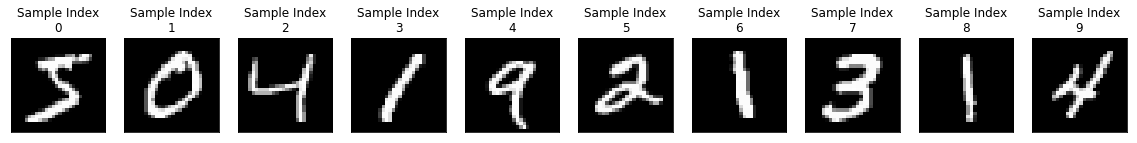

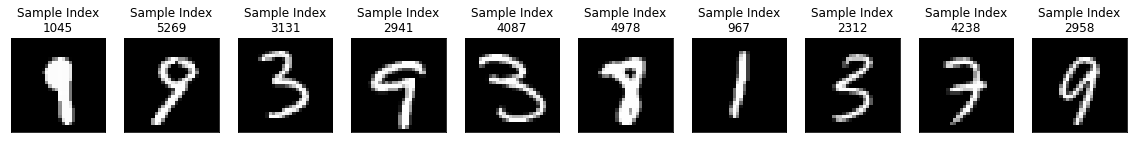

In [34]:
# plot first 10 samples from training data
plot_mnist_sample(mnist_train.train_data, 
                  sample_idx=[i for i in range(10)])
# plot 10 random samples of test data 
plot_mnist_sample(mnist_test.test_data, size=10)


# Check Transformation
- Transform MNIST to [0, 1]
- Check transformation is correct

n.shape: (60000, 28, 28, 1)
torch.Size([1, 28, 28])
Original max values: 255
Transformed max values: 1.0
Reverse back to original, max values: 255
Is original equal to reversed transformed tensor: True


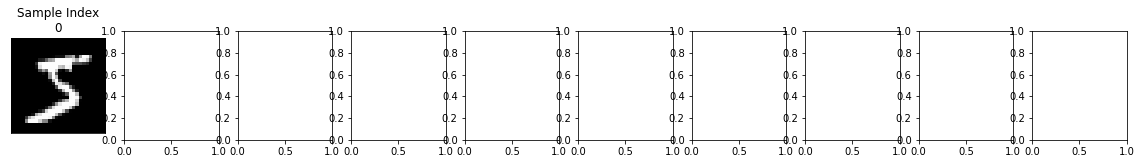

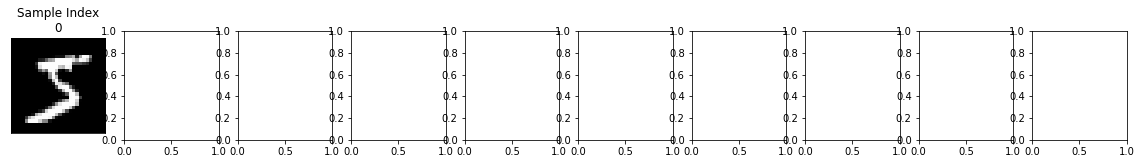

In [35]:
n = mnist_train.train_data.numpy()
n.resize((60000, 28, 28, 1)) # Sample x Height x Width x Channel
print("n.shape:", n.shape) # Sample x Height x Width x Channel

tensor_0 = mnist_train.transform(n[0]) # first sample after transformation
print(tensor_0.size())
# plot first training sample
plot_mnist_sample(tensor_0, sample_idx=[0])
plot_mnist_sample(mnist_train.train_data, sample_idx=[0])

n_0_flatten = n[0, :, :, 0].reshape(784)
print("Original max values:", n_0_flatten.max())
print("Transformed max values:", tensor_0[0, :, :].numpy().max())
tensor_0_flattern_reverse = tensor_0[0, :, :].numpy() * 255
tensor_0_flattern_reverse = tensor_0_flattern_reverse.reshape(784).astype(int)
print("Reverse back to original, max values:", tensor_0_flattern_reverse.max())
print("Is original equal to reversed transformed tensor:",np.equal(n_0_flatten, tensor_0_flattern_reverse).sum() == 784)

# MNIST Data Loader

In [36]:
train_loader = torch.utils.data.DataLoader(mnist_train, 
                        batch_size=args.train_batch_size,
                        shuffle=True, 
                        **kwargs)
test_loader = torch.utils.data.DataLoader(mnist_test, 
                        batch_size=args.test_batch_size,
                        shuffle=True, 
                        **kwargs)

# Using Feed Forward Network as Autoencoder in AAE

In [37]:
x_dim = 784 # input dimension to Encoder
z_dim = 2 # latent space dimension

class Encoder(nn.Module):
    """Encoder of AAE, it extends base class for neural network modules.
    
    Input values to the Encoder are in the range [0.0, 1.0].
    """
    def __init__(self):
        super(Encoder, self).__init__()
        # nn.Linear:
        # Layer of weights and bias that performs linear transformation to incomming data
        # output of each layer: y = Ax + B
        # where A is the weight of the layer and B the bias
        self.lin1 = nn.Linear(x_dim, 1000) # 1000 output dimension with X_dim input dimension 
        self.lin2 = nn.Linear(1000, 1000) # 1000 output dimension with 1000 input dimension
        self.lin3 = nn.Linear(1000, z_dim) # z_dim output dimension from 1000 input dimension
    
    def forward(self, x):
        """Defines the forward computation.
        """
        cur_mode = self.training
        self.train(mode=False)
        
        x = self.lin1(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        x = F.selu(x, inplace=False)
        
        x = self.lin2(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        x = F.selu(x, inplace=False)
        
        x = self.lin3(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        
        self.train(mode=cur_mode)
        
        return x

class Decoder(nn.Module):
    """Decoder of AAE, it extends base class for neural network modules.
    
    Output values of Decoder are in the range [0.0, 1.0].
    """
    def __init__(self):
        super(Decoder, self).__init__()
        self.lin1 = nn.Linear(z_dim, 1000)
        self.lin2 = nn.Linear(1000, 1000)
        self.lin3 = nn.Linear(1000, x_dim)
    
    def forward(self, x):
        cur_mode = self.training
        self.train(mode=False)
        
        x = self.lin1(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        x = F.selu(x, inplace=False)
        
        x = self.lin2(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        x = F.selu(x, inplace=False)
        
        x = self.lin3(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        # ouput values are in range [0.0, 1.0] to match range of input values
        # to the Encoder
        x = F.sigmoid(x)
        
        self.train(mode=cur_mode)
        
        return x

class Discriminator(nn.Module):
    """Discriminator of AAE, it extends base class of neural network modules.
    
    Output of Discriminator is in range [0.0, 1.0]
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.lin1 = nn.Linear(z_dim, 1000)
        self.lin2 = nn.Linear(1000, 1000)
        self.lin3 = nn.Linear(1000, 1)

    def forward(self, x):
        cur_mode = self.training
        self.train(mode=False)
        
        x = self.lin1(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        x = F.selu(x, inplace=False)
        
        x = self.lin2(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        x = F.selu(x, inplace=False)
        
        x = self.lin3(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        x = F.sigmoid(x)
        
        self.train(mode=cur_mode)
        
        return x
    
class AAE(nn.Module):
    """Simple Adversial Autoencoder, it extends base class of neural network modules.
    """
    def __init__(self):
        super(AAE, self).__init__()
        self.nn_enc = Encoder()
        self.nn_dec = Decoder()
        self.nn_dis = Discriminator()
        self.optim_enc = optim.Adam(self.nn_enc.parameters(), lr=1e-5)
        self.optim_dec = optim.Adam(self.nn_dec.parameters(), lr=1e-5)
        self.optim_gen = optim.Adam(self.nn_enc.parameters(), lr=1e-5)
        self.optim_dis = optim.Adam(self.nn_dis.parameters(), lr=1e-5)
        self.model_path = "./aae_model"
        self.log_filename = None
        
    def forward(self, x):
        cur_mode = self.training
        # Change to evaluation mode
        self.train(mode=False)
        z = self.nn_enc(x)
        recon_x = self.nn_dec(z)
        # Change back to previous mode
        self.train(mode=cur_mode)
        return recon_x
    
    def save(self, filename):
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)
            print("Created folder {}".format(self.model_path))
        fname = os.path.join(self.model_path, filename)
        torch.save(self.state_dict(), fname)
        print("Saved {}".format(fname))
        
    def load(self, filename):
        if filename is None:
            return
        try:
            fname = os.path.join(self.model_path, filename)
            self.load_state_dict(torch.load(fname))
            print("Loaded {}".format(fname))
        except:
            print("Error loading")
    
    def clear_log(self):
        if self.log_filename is None:
            return
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)
            print("Created folder {}".format(self.model_path))
        fname = os.path.join(self.model_path, self.log_filename)
        fhnd = open(fname, mode="w", buffering=1)
        fhnd.write("")
        
    def log(self, txt):
        if self.log_filename is None:
            return
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)
            print("Created folder {}".format(self.model_path))
        fname = os.path.join(self.model_path, self.log_filename)
        fhnd = open(fname, mode="a", buffering=1)
        fhnd.write(txt+"\n")
        
def get_recent_model_file(model_path):
    list_files = [os.path.basename(f) for f in glob.glob(os.path.join(model_path, "*.dat"))]
    list_files = sorted(list_files, reverse=True)
    if len(list_files) > 0:
        return list_files[0]
    else:
        return None


In [38]:
nn_aae = AAE()

nn_aae.load(get_recent_model_file("./aae_model"))

if args.cuda:
    nn_aae.cuda()


In [39]:
# Get the training start time
cur_tm = datetime.datetime.now()
str_cur_tm = cur_tm.strftime("%Y%m%d%H%M%S")
print("Start time: {}".format(cur_tm.strftime("%Y-%m-%d %H:%M:%S")))
# Set AAE log filename to simply the training start time
nn_aae.log_filename = str_cur_tm + ".log"
# A constant for ensuring log never goes to -infinity
TINY = 1e-15
# Set AAE to training mode, train function internally sets children network to training mode
# Training mode has any effect only on modules such as Dropout or BatchNorm which we are using for
# encoder, decoder, and discriminators 
nn_aae.train()

# Train networks
for epoch in tqdm.tqdm_notebook(range(1, args.epochs+1), "Epoch"):
    # Training history
    nn_aae.train_tot_recon_loss = 0
    nn_aae.train_tot_gen_loss = 0
    nn_aae.train_tot_dis_loss = 0
    
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.view(-1, 784)
        x = Variable(x)
        if args.cuda:
            x = x.cuda()
        
        # AAE training 
        # AAE Reconstruction phase
        # Clear the gradients of all optimised variables (of type Variable)
        # Train Decoder and Encoder
        nn_aae.optim_dec.zero_grad()
        nn_aae.optim_enc.zero_grad()
        nn_aae.eval()
        recon_x = nn_aae(x)
        nn_aae.train()
        nn_aae.train_recon_loss = F.binary_cross_entropy(recon_x, x, size_average=True)
        nn_aae.train_tot_recon_loss += nn_aae.train_recon_loss.data[0]
        # compute gradient of recon_loss Variable
        nn_aae.train_recon_loss.backward()
        # perform a single optimisation step (parameter update) to decoder
        nn_aae.optim_dec.step()
        # perform a single optimisation step (parameter update) to encoder
        nn_aae.optim_enc.step()
        
        # AAE Regularisation phase
        # Set Generator/Encoder network to evaluation mode 
        # To prevent any effect on modules such as Dropout or BatchNorm
        nn_aae.nn_enc.eval()
        z_fake = nn_aae.nn_enc(x)
        # Train Discriminator first
        # Minimise -log(D(G(z))) depends on Discriminator
        # Discriminator must at least know some idea what is constituted as fake and real
        # Unless Discriminator is initialised with such knowledge, it won't be able to
        # If Discriminator is unable to, Generator will not have incentive to learn
        # In order to incentivise Generator to update its weights, Discriminator is set to learn more on fake and real
        # This then will provide ample gradients (so that D(G(z)) < 0) for Generator
        for _ in range(0, 3):
            # Clear the gradients of all optimised variables (of type Variable)
            nn_aae.optim_dis.zero_grad()
            # Sample real z
            # returns a Tensor filled with random numbers from a normal distribution with
            # zero mean and standard dev. of 5
            z_real = Variable(torch.randn(len(x), z_dim) * 5.0)
            if args.cuda:
                z_real = z_real.cuda()
            
            nn_aae.nn_dis.eval()
            prob_z_real = nn_aae.nn_dis(z_real)
            prob_z_fake = nn_aae.nn_dis(z_fake)
            nn_aae.nn_dis.train()
            nn_aae.train_dis_loss = -torch.mean(torch.log(prob_z_real+TINY) + 
                                            torch.log(1 - prob_z_fake+TINY))
            nn_aae.train_tot_dis_loss += nn_aae.train_dis_loss.data[0]
            nn_aae.train_dis_loss.backward(retain_graph=True)
            nn_aae.optim_dis.step()
        
        # Train generator
        nn_aae.optim_gen.zero_grad()
        nn_aae.nn_enc.train()
        nn_aae.nn_dis.eval()
        prob_z_fake = nn_aae.nn_dis(z_fake)
        nn_aae.nn_dis.train()
        nn_aae.train_gen_loss = -torch.mean(torch.log(prob_z_fake+TINY))
        nn_aae.train_tot_gen_loss += nn_aae.train_gen_loss.data[0]
        nn_aae.train_gen_loss.backward()
        nn_aae.optim_gen.step()
        
    cur_tm = datetime.datetime.now()
    str_cur_tm = cur_tm.strftime("%Y%m%d%H%M%S")
    filename = str_cur_tm + ".dat"
    
    nn_aae.train_avg_recon_loss = nn_aae.train_tot_recon_loss / len(train_loader.dataset)
    nn_aae.train_avg_dis_loss = nn_aae.train_tot_dis_loss / len(train_loader.dataset)
    nn_aae.train_avg_gen_loss = nn_aae.train_tot_gen_loss / len(train_loader.dataset)
    print('Epoch:{} {} AAE recon_loss:{:.6f} dis_loss:{:.6f} gen_loss:{:.6f}'.format(
          epoch, 
          cur_tm.strftime("%Y-%m-%d %H:%M:%S"),
          nn_aae.train_avg_recon_loss, 
          nn_aae.train_avg_dis_loss,
          nn_aae.train_avg_gen_loss
         ))
    nn_aae.log("{}, {}, {}, {}, {}".format(epoch, 
                                              filename,
                                              nn_aae.train_avg_recon_loss,
                                              nn_aae.train_avg_dis_loss, 
                                              nn_aae.train_avg_gen_loss))
    if (epoch % args.save_epoch_interval == 0) or epoch >= args.epochs:
        nn_aae.save(filename)
    

Start time: 2017-09-13 11:22:02


Epoch:1 2017-09-13 11:22:06 AAE recon_loss:0.000623 dis_loss:0.001636 gen_loss:0.001825
Created folder ./aae_model
Epoch:2 2017-09-13 11:22:11 AAE recon_loss:0.000359 dis_loss:0.000895 gen_loss:0.002860
Epoch:3 2017-09-13 11:22:16 AAE recon_loss:0.000277 dis_loss:0.000644 gen_loss:0.003478
Epoch:4 2017-09-13 11:22:20 AAE recon_loss:0.000263 dis_loss:0.001152 gen_loss:0.002941
Epoch:5 2017-09-13 11:22:25 AAE recon_loss:0.000252 dis_loss:0.001426 gen_loss:0.002266
Epoch:6 2017-09-13 11:22:30 AAE recon_loss:0.000247 dis_loss:0.001522 gen_loss:0.002076
Epoch:7 2017-09-13 11:22:34 AAE recon_loss:0.000243 dis_loss:0.001549 gen_loss:0.002026
Epoch:8 2017-09-13 11:22:39 AAE recon_loss:0.000240 dis_loss:0.001590 gen_loss:0.001990
Epoch:9 2017-09-13 11:22:44 AAE recon_loss:0.000238 dis_loss:0.001643 gen_loss:0.001960
Epoch:10 2017-09-13 11:22:48 AAE recon_loss:0.000237 dis_loss:0.001689 gen_loss:0.001934
Saved ./aae_model/20170913112248.dat
Epoch:11 2017-09-13 11:22:53 AAE recon_loss:0.000235 di

Epoch:90 2017-09-13 11:29:24 AAE recon_loss:0.000204 dis_loss:0.003523 gen_loss:0.000920
Saved ./aae_model/20170913112924.dat
Epoch:91 2017-09-13 11:29:28 AAE recon_loss:0.000203 dis_loss:0.003541 gen_loss:0.000912
Epoch:92 2017-09-13 11:29:33 AAE recon_loss:0.000203 dis_loss:0.003559 gen_loss:0.000905
Epoch:93 2017-09-13 11:29:38 AAE recon_loss:0.000203 dis_loss:0.003585 gen_loss:0.000900
Epoch:94 2017-09-13 11:29:42 AAE recon_loss:0.000203 dis_loss:0.003592 gen_loss:0.000895
Epoch:95 2017-09-13 11:29:47 AAE recon_loss:0.000203 dis_loss:0.003608 gen_loss:0.000888
Epoch:96 2017-09-13 11:29:51 AAE recon_loss:0.000203 dis_loss:0.003634 gen_loss:0.000884
Epoch:97 2017-09-13 11:29:56 AAE recon_loss:0.000202 dis_loss:0.003644 gen_loss:0.000880
Epoch:98 2017-09-13 11:30:01 AAE recon_loss:0.000202 dis_loss:0.003662 gen_loss:0.000874
Epoch:99 2017-09-13 11:30:05 AAE recon_loss:0.000202 dis_loss:0.003679 gen_loss:0.000866
Epoch:100 2017-09-13 11:30:10 AAE recon_loss:0.000202 dis_loss:0.003691 g

Epoch:178 2017-09-13 11:36:12 AAE recon_loss:0.000194 dis_loss:0.004059 gen_loss:0.000735
Epoch:179 2017-09-13 11:36:17 AAE recon_loss:0.000194 dis_loss:0.004058 gen_loss:0.000735
Epoch:180 2017-09-13 11:36:21 AAE recon_loss:0.000194 dis_loss:0.004060 gen_loss:0.000734
Saved ./aae_model/20170913113621.dat
Epoch:181 2017-09-13 11:36:26 AAE recon_loss:0.000194 dis_loss:0.004060 gen_loss:0.000734
Epoch:182 2017-09-13 11:36:30 AAE recon_loss:0.000194 dis_loss:0.004060 gen_loss:0.000733
Epoch:183 2017-09-13 11:36:35 AAE recon_loss:0.000194 dis_loss:0.004062 gen_loss:0.000732
Epoch:184 2017-09-13 11:36:40 AAE recon_loss:0.000194 dis_loss:0.004068 gen_loss:0.000732
Epoch:185 2017-09-13 11:36:44 AAE recon_loss:0.000194 dis_loss:0.004067 gen_loss:0.000733
Epoch:186 2017-09-13 11:36:49 AAE recon_loss:0.000194 dis_loss:0.004066 gen_loss:0.000731
Epoch:187 2017-09-13 11:36:53 AAE recon_loss:0.000194 dis_loss:0.004072 gen_loss:0.000731
Epoch:188 2017-09-13 11:36:58 AAE recon_loss:0.000194 dis_loss:

Epoch:266 2017-09-13 11:43:03 AAE recon_loss:0.000190 dis_loss:0.004127 gen_loss:0.000712
Epoch:267 2017-09-13 11:43:08 AAE recon_loss:0.000190 dis_loss:0.004127 gen_loss:0.000711
Epoch:268 2017-09-13 11:43:13 AAE recon_loss:0.000190 dis_loss:0.004124 gen_loss:0.000710
Epoch:269 2017-09-13 11:43:17 AAE recon_loss:0.000189 dis_loss:0.004126 gen_loss:0.000710
Epoch:270 2017-09-13 11:43:22 AAE recon_loss:0.000189 dis_loss:0.004128 gen_loss:0.000711
Saved ./aae_model/20170913114322.dat
Epoch:271 2017-09-13 11:43:27 AAE recon_loss:0.000189 dis_loss:0.004130 gen_loss:0.000710
Epoch:272 2017-09-13 11:43:31 AAE recon_loss:0.000189 dis_loss:0.004127 gen_loss:0.000710
Epoch:273 2017-09-13 11:43:36 AAE recon_loss:0.000189 dis_loss:0.004131 gen_loss:0.000710
Epoch:274 2017-09-13 11:43:40 AAE recon_loss:0.000189 dis_loss:0.004127 gen_loss:0.000709
Epoch:275 2017-09-13 11:43:45 AAE recon_loss:0.000189 dis_loss:0.004127 gen_loss:0.000711
Epoch:276 2017-09-13 11:43:50 AAE recon_loss:0.000189 dis_loss:

# Plot Training History

   Epoch                 file  recon loss  dis loss  gen loss
0      1   20170913112206.dat    0.000623  0.001636  0.001825
1      2   20170913112211.dat    0.000359  0.000895  0.002860
2      3   20170913112216.dat    0.000277  0.000644  0.003478
3      4   20170913112220.dat    0.000263  0.001152  0.002941
4      5   20170913112225.dat    0.000252  0.001426  0.002266
(300, 5)


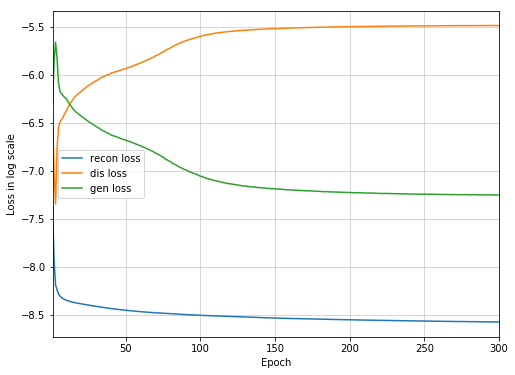

In [44]:
df_train_hist = pd.read_csv("./aae_model/20170913112202.log", header=None)
df_train_hist.columns = ["Epoch", "file", "recon loss", "dis loss", "gen loss"]
print(df_train_hist.head())
print(df_train_hist.shape)

df_train_hist["recon loss"] = np.log(df_train_hist["recon loss"])
df_train_hist["dis loss"] = np.log(df_train_hist["dis loss"])
df_train_hist["gen loss"] = np.log(df_train_hist["gen loss"])

fig, ax = plt.subplots(figsize=(8,6))
df_train_hist.plot(x="Epoch",y="recon loss",ax=ax)
df_train_hist.plot(x="Epoch",y="dis loss", ax=ax)
df_train_hist.plot(x="Epoch",y="gen loss", ax=ax)
ax.grid(linewidth=0.5)
ax.set_ylabel("Loss in log scale")

In [45]:
def create_latent(nn_enc, loader):
    '''
    Create the latent representation for the samples in loader
    Return:
        z_values: numpy array with the latent representations
        labels: the labels corresponding to the latent representations
    '''
    nn_enc.eval()
    labels = []
    for batch_idx, (x, y) in enumerate(loader):
        x = x.view(-1, 784)
        x, y = Variable(x), Variable(y)
        if args.cuda:
            x, y = x.cuda(), y.cuda()
        
        labels.extend(y.data.tolist())
        # reconstruction phase
        z = nn_enc(x)
        if batch_idx > 0:
            z_values = np.concatenate((z_values, np.array(z.data.tolist())))
        else:
            z_values = np.array(z.data.tolist())
    labels = np.array(labels)
    return z_values, labels


def create_sample(nn_dec, z_values):
    """Evaluate Decoder.
    
    Return FloatTensor of shape [sample count, 28, 28].
    """
    z = torch.from_numpy(z_values).float()
    z = Variable(z)
    if args.cuda:
        z = z.cuda()
    nn_dec.eval()
    recon_x = nn_dec(z)
    recon_x = recon_x.view(len(recon_x.data), 28, -1)
    if args.cuda:
        recon_x = recon_x.cpu()
    return recon_x.data

# Reconstruction of MNIST Training Samples

-0.0499003664244 4.96971190012
0.0331540112118 4.99452768339


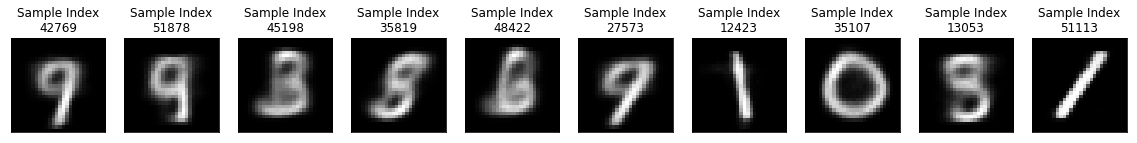

In [49]:
# Latent space is tuned towards Gaussian distribution of 0 mean and 5 standard deviation

z_values, _ = create_latent(nn_aae.nn_enc, train_loader)
print(z_values[:,0].mean(), z_values[:,0].std())
print(z_values[:,1].mean(), z_values[:,1].std())
recon_x = create_sample(nn_aae.nn_dec, z_values)
plot_mnist_sample(recon_x)

# Latent Code of MNIST Training Samples

-0.0499003664244 4.96971190012
0.0331540112118 4.99452768339


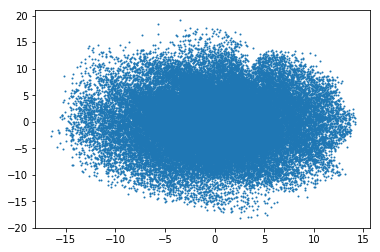

In [54]:
z_values, labels = create_latent(nn_aae.nn_enc, train_loader)
print(z_values[:,0].mean(), z_values[:,0].std())
print(z_values[:,1].mean(), z_values[:,1].std())
plt.scatter(z_values[:,0], z_values[:,1], s=1)

# Reconstruction of MNIST Testing Samples

-0.181365882172 4.87758835154
0.250209496557 4.79553759296


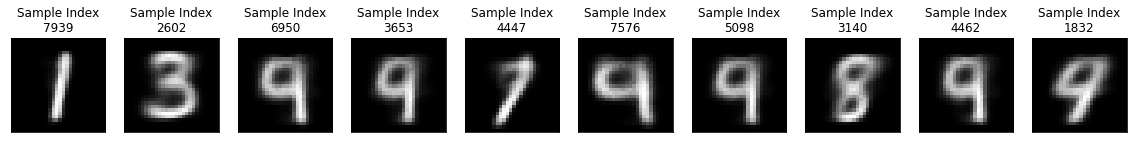

In [55]:
z_values, _ = create_latent(nn_aae.nn_enc, test_loader)
print(z_values[:,0].mean(), z_values[:,0].std())
print(z_values[:,1].mean(), z_values[:,1].std())
recon_x = create_sample(nn_aae.nn_dec, z_values)
plot_mnist_sample(recon_x)

# Latent Code of MNIST Testing Samples

-0.181365882172 4.87758835154
0.250209496557 4.79553759296


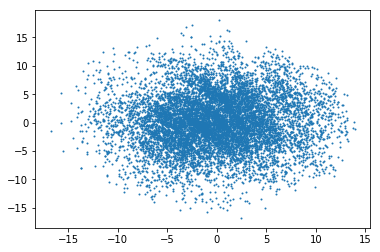

In [56]:
z_values, labels = create_latent(nn_aae.nn_enc, test_loader)
print(z_values[:,0].mean(), z_values[:,0].std())
print(z_values[:,1].mean(), z_values[:,1].std())
plt.scatter(z_values[:,0], z_values[:,1], s=1)

# Reconstruction of images at specific latent code

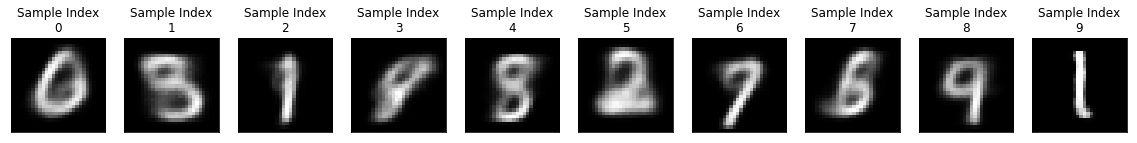

In [101]:
z = Variable(torch.FloatTensor([[-5,-5], [-5,5], [5,5], [5,-5], [0,0], [-5,0], [5,0], [0,-5], [0,5], [12,12]]))
if args.cuda:
    z = z.cuda()
nn_aae.nn_dec.eval()
recon_x = nn_aae.nn_dec(z)
if args.cuda:
    recon_x = recon_x.cpu()
plot_mnist_sample(recon_x.view(-1, 28,28).data, sample_idx=[0,1,2,3,4,5,6,7,8,9])

# Using Variational Autoencoder in AAE (Not completed)

In [ ]:
x_dim = 784
z_dim = 2
"""
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(x_dim, 500)
        self.fc21 = nn.Linear(500, z_dim)
        self.fc22 = nn.Linear(500, z_dim)
        self.fc3 = nn.Linear(z_dim, 500)
        self.fc4 = nn.Linear(500, x_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        # perform element-wise exp(logvar/2)
        std = logvar.mul(0.5).exp_()
        # sample from normal distribution of mean=0 and std=1
        # fills this tensor (eps) with elements samples from the 
        # normal distribution parameterized by mean=0 and std=1.
        if args.cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def latent(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return z
    
    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
"""
class VAE_Encoder(nn.Module):
    def __init__(self):
        super(VAE_Encoder, self).__init__()
        self.fc1 = nn.Linear(x_dim, 500)
        self.fc21 = nn.Linear(500, z_dim)
        self.fc22 = nn.Linear(500, z_dim)
        self.relu = nn.ReLU()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        # perform element-wise exp(logvar/2)
        std = logvar.mul(0.5).exp_()
        # sample from normal distribution of mean=0 and std=1
        # fills this tensor (eps) with elements samples from the 
        # normal distribution parameterized by mean=0 and std=1.
        if args.cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
         # wrap tensor into torch.autograd.Variable (automatic differentiation)
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return z
        
class VAE_Decoder(nn.Module):
    def __init__(self):
        super(VAE_Decoder, self).__init__()
        self.fc3 = nn.Linear(z_dim, 500)
        self.fc4 = nn.Linear(500, x_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.nn_enc = VAE_Encoder()
        self.nn_dec = VAE_Decoder()

    def latent(self, x):
        z = self.nn_enc.forward(x)
        return z
    
    def decode(self, z):
        return self.nn_dec.forward(z)

    def forward(self, x):
        mu, logvar = self.nn_enc.encode(x)
        z = self.nn_enc.reparametrize(mu, logvar)
        return self.nn_dec(z), mu, logvar

In [ ]:
nn_vae = VAE()
nn_vae_dis = Discriminator()
if args.cuda:
    nn_vae.cuda()
    nn_vae_dis.cuda()

print("VAE Modules")
for idx, m in enumerate(nn_vae.modules()):
    print(idx, '->', m)
print("VAE Parameters")
for param in nn_vae.parameters():
    print(type(param.data), param.size())
    
print("Discriminator")
for param in nn_vae_dis.parameters():
    print(type(param.data), param.size())

In [ ]:
TINY = 1e-15
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, 
                                 weight=None,
                                 size_average=False)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return BCE + KLD

In [ ]:
optim_vae = optim.Adam(nn_vae.parameters(), lr=0.001)
optim_vae_gen = optim.Adam(nn_vae.nn_enc.parameters(), lr=0.001)
optim_vae_dis = optim.Adam(nn_vae_dis.parameters(), lr=0.001)

In [ ]:
nn_vae.train()
nn_vae.nn_enc.train()
nn_vae.nn_dec.train()
nn_vae_dis.train()
for epoch in tqdm.tqdm_notebook(range(1, args.epochs+1), "Epoch"):
    train_loss = 0
    total_dis_loss = 0
    total_gen_loss = 0
    for batch_idx, (x, y) in enumerate(mnist_train_loader):
        x = x.view(-1, 784)
        x = Variable(x)
        if args.cuda:
            x, y = x.cuda(), y.cuda()
        
        # reconstruction phase
        optim_vae.zero_grad()
        nn_vae.nn_dec.zero_grad()
        nn_vae.nn_enc.zero_grad()
        recon_batch, mu, logvar = nn_vae(x)
        loss = loss_function(recon_batch, x, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optim_vae.step()
        
        # regularisation phase
        # clear the gradients of all optimised variables (of type Variable)
        optim_vae_dis.zero_grad()
        optim_vae_gen.zero_grad()
        # sample real z
        # returns a Tensor filled with random numbers from a normal distribution
        # with zero mean and standard deviation of 1
        z_real = Variable(torch.randn(len(x), z_dim) * 1.0)
        if args.cuda:
            z_real = z_real.cuda()
        # set generator network to evaluation mode 
        # this has any effect only on modules such as Dropout or BatchNorm
        nn_vae.nn_enc.eval()
        z_fake = nn_vae.nn_enc(x)
        prob_z_real = nn_vae_dis(z_real)
        prob_z_fake = nn_vae_dis(z_fake)
        dis_loss = -torch.mean(torch.log(prob_z_real+TINY) + 
                               torch.log(1 - prob_z_fake+TINY))
        total_dis_loss += dis_loss.data[0]
        dis_loss.backward()
        optim_vae_dis.step()

        # set generator to training mode
        nn_vae.nn_enc.train()
        optim_vae_gen.zero_grad()
        z_fake = nn_vae.nn_enc(x)
        prob_z_fake = nn_vae_dis(z_fake)
        gen_loss = -torch.mean(torch.log(prob_z_fake+TINY))
        total_gen_loss += gen_loss.data[0]
        gen_loss.backward()
        optim_vae_gen.step()
        
        if (not args.log_interval is None) and (batch_idx % args.log_interval == 0):
            print('Epoch:{} [{}/{} ({:.0f}%)] recon_loss:{:.6f} dis_loss:{:.6f} gen_loss:{:.6f}'.format(
                epoch, batch_idx * len(x), len(mnist_train_loader.dataset),
                100. * batch_idx / len(mnist_train_loader),
                loss.data[0] / len(x),
                dis_loss.data[0] / len(x),
                gen_loss.data[0] / len(x)
                ))

    print('Epoch:{} avg recon_loss:{:.6f} avg dis_loss:{:.6f} avg gen_loss:{:.6f}'.format(
          epoch, train_loss / len(mnist_train_loader.dataset),
          total_dis_loss / len(mnist_train_loader.dataset),
          total_gen_loss / len(mnist_train_loader.dataset)))
    

In [ ]:
def vae_latent(nn_vae, loader):
    '''
    Create the latent representation for the samples in loader
    Return:
        z_values: numpy array with the latent representations
        labels: the labels corresponding to the latent representations
    '''
    nn_vae.eval()
    labels = []
    for batch_idx, (x, y) in enumerate(loader):
        x = x.view(-1, 784)
        x, y = Variable(x), Variable(y)
        if args.cuda:
            x, y = x.cuda(), y.cuda()
        
        labels.extend(y.data.tolist())
        # reconstruction phase
        z = nn_vae.latent(x)
        if batch_idx > 0:
            z_values = np.concatenate((z_values, np.array(z.data.tolist())))
        else:
            z_values = np.array(z.data.tolist())
    labels = np.array(labels)
    return z_values, labels


def vae_recon(nn_vae, z_values):
    """Evaluate Decoder.
    
    Return FloatTensor of shape [sample count, 28, 28].
    """
    z = torch.from_numpy(z_values).float()
    z = Variable(z)
    if args.cuda:
        z = z.cuda()
    nn_vae.eval()
    recon_x = nn_vae.decode(z)
    recon_x = recon_x.view(len(recon_x.data), 28, -1)
    if args.cuda:
        recon_x = recon_x.cpu()
    return recon_x.data

In [ ]:
# Reconstruction of MNIST Training Samples
z_values, _ = vae_latent(nn_vae, mnist_train_loader)
print(z_values[:,0].mean(), z_values[:,0].std())
print(z_values[:,1].mean(), z_values[:,1].std())
recon_x = vae_recon(nn_vae, z_values)
plot_mnist_sample(recon_x)


In [ ]:
z_values, labels = vae_latent(nn_vae, mnist_train_loader)
plt.plot(z_values[:,0], z_values[:,1], ".")

In [ ]:
# Reconstruction of MNIST Testing Samples
z_values, _ = vae_latent(nn_vae, mnist_test_loader)
print(z_values[:,0].mean(), z_values[:,0].std())
print(z_values[:,1].mean(), z_values[:,1].std())
recon_x = vae_recon(nn_vae, z_values)
plot_mnist_sample(recon_x)

In [ ]:
z_values, labels = vae_latent(nn_vae, mnist_test_loader)
plt.plot(z_values[:,0], z_values[:,1], ".")